# 準備

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import time 

import tensorflow as tf
from scipy.integrate import solve_ivp

# 微分方程式右辺の定義

[https://github.com/titu1994/tfdiffeq/blob/master/examples/lorenz_attractor.py](https://github.com/titu1994/tfdiffeq/blob/master/examples/lorenz_attractor.py) 参考に作成

x のTensorを受け取り df/dt のTensorを返す関数を定義する


In [2]:


# this class code is inherited from
# https://github.com/titu1994/tfdiffeq/blob/master/examples/lorenz_attractor.py
# class Lorenz(tf.keras.Model):
class Lorenz(object):
    """ defines Lorenz equation.
        dX/dt=f(X),
    where X = (x,y,z) is a three dimensional vector.
     arg:
        sigma,beta,rho : basic parameters of Lorenz equation
        x : A tensor of three dimensional state vector.
     returns:
      dX_dt : tensor of f(X)
    """
    def __init__(self, sigma=10., beta=8 / 3., rho=28., **kwargs):
        super().__init__(**kwargs)

        self.sigma = float(sigma)
        self.beta = float(beta)
        self.rho = float(rho)

    def __call__(self, t, x):
        """ x here is [x, y, z] """
        # x = tf.cast(x, tf.float64)

        dx_dt = self.sigma * (x[1] - x[0])
        dy_dt = x[0] * (self.rho - x[2]) - x[1]
        dz_dt = x[0] * x[1] - self.beta * x[2]

        dX_dt = tf.stack([dx_dt, dy_dt, dz_dt])
        return dX_dt


## グラフの作成

In [3]:
# state variable x
x = tf.placeholder(dtype=tf.float64, shape=(3), name='x')

# lorenz equation
f_lorenz = Lorenz()

# operator for getting r.h.s. of ode
fx = f_lorenz(None, x)  # r.h.s. of ODE


### Session 開始

In [4]:
sess = tf.Session()
sess.run(tf.initializers.global_variables())

xの初期値

In [5]:
x0 = np.array([1, 10, 10], dtype=np.float64)   # initial value

動いているかチェック

In [14]:
xv = sess.run(x, feed_dict = {x:x0})
print('###value of x###')
print(xv) #   [1,10,10]

print('###value of f(x)###')
print(sess.run(fx, feed_dict={x:x0})) # (f_x(x0)=90, f_y(x0)=8, f_z(x0)=-50/3)



###value of x###
[ 1. 10. 10.]
###value of f(x)###
[ 90.           8.         -16.66666667]


## ODEソルバーによる数値計算

積分時間の設定

In [7]:
#integrating time
dt=0.01
tstart=0.0
tend=100.0
ts=np.arange(tstart, tend+dt, dt)  # 表示のため、0.01ステップで値を出力させる

odeソルバーに渡すラッパー関数の作成


In [8]:
def f_lorenz_tf(t,xt):
    return sess.run(fx, feed_dict={x: xt})

ソルバーによる解軌道の計算

In [15]:
start_time =time.time() # measurement of time
sol_lorenz = solve_ivp(fun=f_lorenz_tf,
                       t_span=[tstart, tend], y0=x0, t_eval=ts)
integration_time_tf = time.time() - start_time
t_lo = sol_lorenz['t']   # 各ステップの時刻を取得
x_lo = sol_lorenz['y']  # 各ステップのx(t)の値を取得

print("processing time (tf) %.5f" % integration_time_tf)


processing time (tf) 3.03116


# 結果のmatplotlibによる表示

Text(0.5, 0.92, 'Lorenz Attractor')

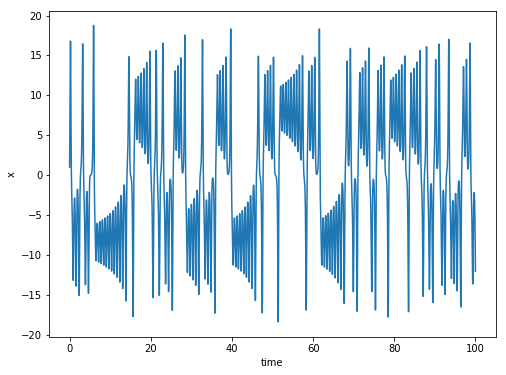

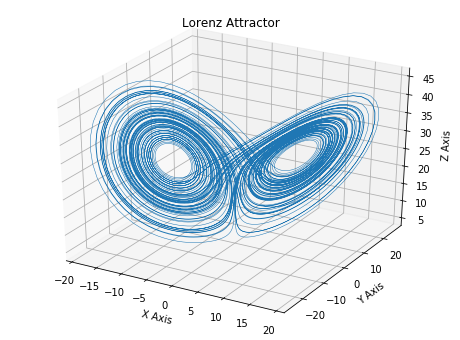

In [10]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)

ax.plot(t_lo,x_lo[0],'-')
ax.set_xlabel('time')
ax.set_ylabel('x')
# 3dim phase space
fig3 = plt.figure(figsize=(8,6))
ax3 = fig3.add_subplot(111,projection='3d')

ax3.plot(x_lo[0], x_lo[1], x_lo[2], '-', lw=0.5)
ax3.set_xlabel("X Axis")
ax3.set_ylabel("Y Axis")
ax3.set_zlabel("Z Axis")
ax3.set_title("Lorenz Attractor")

# numpyのみとの比較
numpyのみを使って微分方程式を計算した場合と比較してみます。

まずtensorflowを使わずにローレンツ方程式のfを定義。最後のreturn文以外は同じ処理になります。

In [11]:
class Lorenz_np(object):

    def __init__(self, sigma=10., beta=8 / 3., rho=28., **kwargs):
        self.sigma = float(sigma)
        self.beta = float(beta)
        self.rho = float(rho)

    def __call__(self, t, x):
        """ x here is [x, y, z] """
        dxdt=  self.sigma * ( x[1] - x[0])
        #dxdt=  self.sigma *  x[1] - self.sigma*x[0]
        dydt= x[0] * (self.rho- x[2] ) - x[1]
        dzdt= x[0]*x[1]-self.beta*x[2]
        return np.array([dxdt,dydt,dzdt   ])

この関数をodeソルバーに渡して積分します。

In [12]:
f_lorenz_np = Lorenz_np()
start_time = time.time()  # measurement of time
sol_lorenz_np = solve_ivp(fun=f_lorenz_np,
                          t_span=[tstart, tend], y0=x0, t_eval=ts)
integration_time_np= time.time() - start_time
print("processing time (numpy) %.5f" % integration_time_np)

t_lo_np = sol_lorenz_np['t']
x_lo_np = sol_lorenz_np['y']

processing time (numpy) 0.24503


解軌道を比較してみます。

Text(0.5, 0.92, 'Lorenz Attractor')

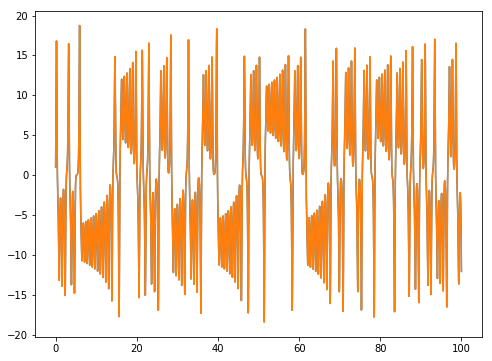

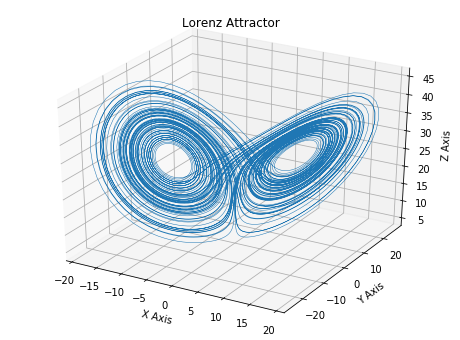

In [13]:
fig3=plt.figure(figsize=(8,6))
ax3=fig3.add_subplot(111)

ax3.plot(t_lo,x_lo[0],'-')
ax3.plot(t_lo_np,x_lo_np[0],'-')
# 3d
fig4 = plt.figure(figsize=(8,6))
ax4 = fig4.add_subplot(111,projection='3d')

ax4.plot(x_lo_np[0], x_lo_np[1], x_lo_np[2], '-', lw=0.5)
ax4.set_xlabel("X Axis")
ax4.set_ylabel("Y Axis")
ax4.set_zlabel("Z Axis")
ax4.set_title("Lorenz Attractor")